<center><font size="6">Хакатон от Моторики</font>

[Третий этап](https://www.kaggle.com/competitions/motorica-advanced-gesture-classification)

Команда 1

**Задача:**  Построить классификационную модель, которая по показаниям оптомиографических датчиков будет определять жест оператора протеза кисти во время записи данных, что отражено в значении целевой переменной. 

Имеется три оператора, выполнявшие некоторую последовательность жестов. В результате наблюдений получены показания датчиков в виде непрерывного временного ряда. 

Список файлов, в котором символ * обозначает индекс оператора:
* X\_train\_*.npy - обучающая выборка, имеющая размерности "наблюдения, датчики, время";
* X\_test\_ dataset\_*.pkl - тестовая выборка, имеющая размерности "наблюдения, датчики, время";
* sample_submission.csv - некоторое решение задачи, из которого можно взять формат загрузки данных на Kaggle;
* y\_train\_*.npy - целевая переменная для обучающей выборки, которая содержит следующие классы:

| Номер <br> класса | Описание жеста |
| :---: | :--- |
| "-1"  |  потенциально "битые" данные |
| "0"  |  жест "open" - разгиб всех пальцев |
| "1"  |  жест "пистолет" |
| "2"  |  сгиб большого пальца |
| "3"  |  жест "ok" |
| "4"  |  жест "grab" |

* functions.py - библиотека функций, применяемых в данном ноутбуке.

# Import библиотек и описание функций

In [21]:
# Установка версий программных пакетов
#!pip install -r ../requirements.txt -q

In [5]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import pickle

from zipfile import ZipFile

# отображать по умолчанию длину датафрейма
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# Логгирование процесса
from comet_ml import Experiment

# библиотека взаимодействия с интерпретатором
import sys, os, json
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# отображение элементов массива не в экспоненциальном формате
np.set_printoptions(suppress=True)

In [6]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')
from utils import figures
from utils.functions import config_reader

# Импортируем константы из файла config
path_to_config = '../config/data_config.json'
config = config_reader(path_to_config)

In [7]:
# константы и глобальные параметры данных
PATH = config['PATH']
GEST = config['GEST']          # количество основных жестов (кроме 'битых' данных)
Pilots = config['Pilots']     # количество пилотов (независимых рядов данных)
SENS = config['SENS']         # количество датчиков

X_train = ['' for p in range(Pilots)]  # список объектов X_train
y_train = ['' for p in range(Pilots)]  # список объектов y_train
X_test = ['' for p in range(Pilots)]   # список объектов X_test

t_train = ['' for p in range(Pilots)]   # список длин X_train и y_train (кол-во временных тиков)
t_test = [0 for p in range(Pilots)]     # список с общим количеством временных тиков в X_test
s_test = ['' for p in range(Pilots)]    # список с количеством событий в X_test
tt_test = [[] for p in range(Pilots)]   # список списков с длинами событий в X_test

In [ ]:
experiment = Experiment(
    api_key = config.api_key, 
    project_name =config.project_name,
    workspace = config.workspace,
);
experiment.set_name('EDA') # имя эксперимента

# Загрузка данных

In [8]:
# Словарь для последующей агрегации данных. Изначально прописаны названия файлов в архиве
mounts = config.mounts.toDict()
for i in mounts.keys():
    mounts[int(i)] = mounts.pop(i)

mounts

{1: {'path_X_train': 'X_train_1.npy',
  'path_y_train': 'y_train_1.npy',
  'path_X_test_dataset': 'X_test_dataset_1.pkl'},
 2: {'path_X_train': 'X_train_2.npy',
  'path_y_train': 'y_train_2.npy',
  'path_X_test_dataset': 'X_test_dataset_2.pkl'},
 3: {'path_X_train': 'X_train_3.npy',
  'path_y_train': 'y_train_3.npy',
  'path_X_test_dataset': 'X_test_dataset_3.pkl'}}

In [9]:
# Чтение данных из архива (без распаковки архива)
path_to_zip = os.path.join(PATH, 'motorica-advanced-gesture-classification.zip')

for mount_name, mount in mounts.items():  # ключи-int; значения - массивы
    mount['X_train'] = np.load(path_to_zip)[mounts[mount_name]['path_X_train']]
    mount['y_train'] = np.load(path_to_zip)[mounts[mount_name]['path_y_train']]
    
for i in range(config.Pilots):
    with ZipFile(path_to_zip) as myzip:
        with myzip.open(mounts[i+1]['path_X_test_dataset']) as myfile:
            mounts[i+1]['X_test_dataset'] = pickle.load(myfile)
    print(f"Количество наблюдений пилота №{i+1}: {len(mounts[i+1]['X_test_dataset'])}")

Количество наблюдений пилота №1: 899
Количество наблюдений пилота №2: 855
Количество наблюдений пилота №3: 861


In [10]:
# загрузка обучающей выборки и меток классов, тестовой выборки
X_test_raw = ['' for p in range(config.Pilots)]

for p in range(config.Pilots):
    X_train[p] = mounts[p+1]['X_train']
    t_train[p] = mounts[p+1]['X_train'].shape[0]
    
    y_train[p] = mounts[p+1]['y_train']
    
    if y_train[p].size == t_train[p]:
        print(f'длина обучающей выборки пилота №{p+1} = {t_train[p]}')
    else:
        print(f'длина обучающей выборки и меток классов пилота №{p+1} не совпадают!')
    
    #with open(os.path.join(PATH, 'X_test_dataset_' + f'{p+1}' + '.pkl'), 'rb') as file:
    X_test_raw[p] = config.mounts[p+1]['X_test_dataset'][p]

длина обучающей выборки пилота №1 = 24030
длина обучающей выборки пилота №2 = 23202
длина обучающей выборки пилота №3 = 23177


In [11]:
# смотрим на исходные данные X_train
print(f"Тип данных X_train: {type(mounts[1]['X_train'])}")
print(f"Размерность файла X_train_1: {mounts[1]['X_train'].shape} - время, датчики")
print(f"X_train первого пилота: \n {mounts[1]['X_train']}")

Тип данных X_train: <class 'numpy.ndarray'>
Размерность файла X_train_1: (24030, 50) - время, датчики
X_train первого пилота: 
 [[2711   16 1803 ...    8   14    7]
 [2712   10 1802 ...    6   12    6]
 [2711   13 1803 ...    5   16    8]
 ...
 [2707   16 1851 ...    6   13    6]
 [2707   18 1850 ...    8   12    6]
 [2710   16 1851 ...    9   11    8]]


In [12]:
# смотрим на исходные данные y_train
print(f"Тип данных y_train: {type(mounts[1]['y_train'])}")
print(f"Размерность файла y_train_1: {mounts[1]['y_train'].shape} - временной период")
print(f"y_train первого пилота: \n {mounts[1]['y_train']}")

Тип данных y_train: <class 'numpy.ndarray'>
Размерность файла y_train_1: (24030,) - временной период
y_train первого пилота: 
 [0 0 0 ... 3 3 3]


# Обзор файла `X_test_dataset`

In [13]:
# смотрим на исходные данные X_test
print(f"Тип данных X_test: {type(mount['X_test_dataset'])}")
print(f"Тип данных X_test для пилота 1 : {type(mount['X_test_dataset'][1])}")
print(f"Размерность X_test для пилота 1: {mount['X_test_dataset'][1].shape} - количество датчиков, периоды времени")
print(f"X_test первого пилота, наблюдение '0', начальное и последнее значение: {mount['X_test_dataset'][1][0][[0,-1]]}")

Тип данных X_test: <class 'list'>
Тип данных X_test для пилота 1 : <class 'numpy.ndarray'>
Размерность X_test для пилота 1: (50, 256) - количество датчиков, периоды времени
X_test первого пилота, наблюдение '0', начальное и последнее значение: [1370 1417]


In [14]:
for mount_name, mount in mounts.items():
    X_test_dataset = mount['X_test_dataset']
    print(f"subject {mount_name}")
    shapes, counts = np.unique(
        [arr.shape for arr in X_test_dataset],
        return_counts=True,
        axis=0
    )
    for shape, count in zip(shapes, counts):
        print(f"\tshape {tuple(shape)} appears {count} times.")

subject 1
	shape (50, 105) appears 303 times.
	shape (50, 181) appears 299 times.
	shape (50, 256) appears 297 times.
subject 2
	shape (50, 105) appears 286 times.
	shape (50, 181) appears 285 times.
	shape (50, 256) appears 284 times.
subject 3
	shape (50, 105) appears 291 times.
	shape (50, 181) appears 282 times.
	shape (50, 256) appears 288 times.


*Отобразим три различных наблюдения первого пилота*

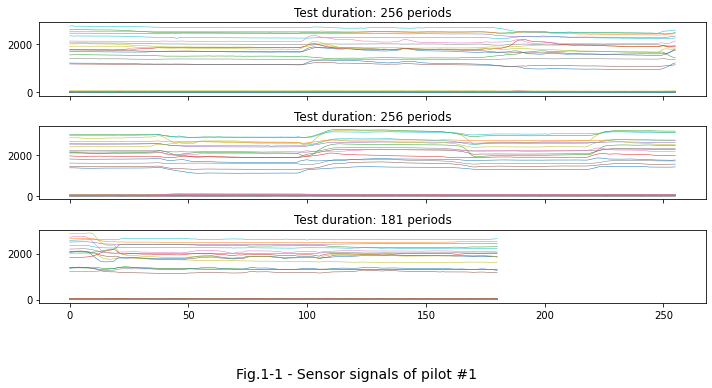

In [15]:
figures.get_signals_plot(data=mount['X_test_dataset'], mounts=mounts, test_id=[3,1,8], plot_counter='1-1')
#experiment.log_figure(figure_name='fig_1-1') # логгируем график 

In [16]:
active_sensors, passive_sensor = figures.get_sensor_list(Pilot_id=1, mounts=mounts, print_active=True, level_boundary=config['level_boundary'])

Active sensors of pilot 1 : [0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38]
Passive sensors of pilot 1 : [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 16, 18, 20, 22, 23, 25, 26, 28, 31, 32, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [17]:
figures.get_all_sensors_plot(Pilot_id=1, timesteps=[0,107], mounts=mounts, plot_counter='1-2')
#experiment.log_image('../logs_and_figures/fig_1-2.png') # логгируем картинку

<center> <img src = "../logs_and_figures/fig_1-2.png"> </center>

На рис.2 изображается сигнал датчиков во времени. Относительные амплитуды некоторых датчиков имеют значительный перепад. Отметим, что датчики можно разделить по средней величине сигнала на 2 группы:
* активные (0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38), величина сигнала которых превышает 200;
* пассивные (все остальные), средняя величина менее 200.

Отобразим обе группы датчиков раздельно.

In [18]:
figures.get_active_passive_sensors_plot(Pilot_id=1, timesteps=[0,107], mounts=mounts, level_boundary=config['level_boundary'], plot_counter='1-3')
#experiment.log_image('../logs_and_figures/fig_1-3.png') # логгируем картинку

<center> <img src = "../logs_and_figures/fig_1-3.png"> </center>

На рис.3 изображены диаграммы активных (слева) и пассивных (справа) датчиков. Отметим, что в районе 50 временного промежутка изменение сигнала достаточно чётко просматривается, несмотря на его относительно небольшой перепад.

# Поиск периода времени, в котором изменился класс жеста

Выберем произвольно: пилота №3; проанализируем показания датчиков 0 и 2 во временной период c 100 по 300.

In [19]:
figures.get_signal_and_train_plots(Pilot_id=3, timesteps=[100,300], sensors=[0,2], mounts=mounts, plot_counter='1-4')
#experiment.log_image('../logs_and_figures/fig_1-4.png'); # логгируем картинку

<center> <img src = "../logs_and_figures/fig_1-4.png"> </center>

На рис.4 изображена диаграмма изменения сигнала датчиков (сверху), на которой наблюдается скачкообразные изменения сигнала датчиков. На диаграмме снизу показано два изменения сигнала манипулятора:   
- в районе 175 временного промежутка класс жеста изменяется с 0 до 2;
- в районе 255 временного промежутка класс жеста изменяется с 2 до 0;

Сравнивая обе диаграммы отметим отсутствие четкого характера изменения сигнала при возвращении к 0 классу жеста, а также запаздывание сигналов датчиков относительно манипулятора из-за задержки реакции оператора.

Проверим производную сигнала датчиков и его нормализованное значение.

In [20]:
figures.get_signal_derivative_and_normalized_plot(Pilot_id=1, timesteps=[100,450], sensors=[0,2], mounts=mounts, plot_counter='1-5')
#experiment.log_image('../logs_and_figures/fig_1-5.png'); # логгируем картинку 

<center> <img src = "../logs_and_figures/fig_1-5.png"> </center>

На рис.5 изображена диаграмма производной сигналов датчиков, квадрат производной сигналов и их нормализованные значения. Анализируя диаграммы совместно отметим, что начало жеста невозможно определить по величине сигнала. Кроме того, характерный паттерн изменения сигнала отсутствует.

In [19]:
experiment.end();

# Характерные уровни датчиков

Выделим из данных X_train участки, где жест не меняется. Для этого при разделении на эпохи зададим следующие параметры:

    epochs = mne.Epochs(
        ...,
        tmin=-1 * 1.5,
        tmax=1 * 0,
        ...
    )

Таким образом, получим сэмплы длиной 46 временных тиков, которые заканчиваются в момент времени, когда подается команда манипулятором.
Поскольку наблюдения были построены таким образом, что команда манипулятора подавалась с периодичностью 77 временных тиков, мы 
можем считать, что с 31 по 77 временной тик (так мы выделили сэмплы) переход к новому жесту уже практически завершился 
или находится в завершающей фазе и данные y_train соответствуют фактическому состоянию кисти пилота.

Наблюдения для каждого пилота были разбиты на три участка, условно обозначенные:

b - первая треть наблюдения по времени,
p - вторая треть наблюдения,
e - финальная треть наблюдения, включенного в X_train.

На полученных данных построим боксплоты датчиков в разрезе жестов. Рассмотрим показания 2-го и 3-го датчиков первого пилота.
Мы видим, что для каждого жеста есть характерные уровни показаний датчиков. Для некоторых жестов интервалы характерных значений 
хорошо дифференцируются, для остальных - интервалы частично перекрываются.

![boxplot1](../logs_and_figures/fig_1-6.png "Рис.6 - показания датчиков №2,3 первого пилота")
#### <center>Рис.6 - показания датчиков №2,3 первого пилота

Обратим внимание на еще одну особенность - постепенное "сползание" характерных уровней датчиков по времени. Т.е., к примеру,
интервал показаний датчика в положении "open" в первой трети наблюдения (красные бары) заметно отличается от интервала показаний того
же датчика в последней трети наблюдения (фиолетовые бары). Для выявления особенностей проведения наблюдений, которые приводят к 
такому эффекту, (это могут быть нагревание кожи, смещение датчиков или другие) необходимы дополнительные данные.

Так же можно обратить внимание, что так называемые датчики "засветки", ведут себя по разному:

показания датчика 46 чувствительны к выполняемому жесту и существенно "плывут" со временем,

датчик 47 практически нечувствителен к жестам, но со временем есть небольшое "сползание" уровня сигнала,

а датчик 48 реагирует на жесты "граб" и "ок", но его показания практически не меняются со временем.

![boxplot2](../logs_and_figures/fig_1-7.png)
#### <center>Рис.7 - показания датчиков №47,48 первого пилота


В папке boxplots для ознакомления выложены боксплоты по всем датчикам для трех пилотов.

# Промежуточные выводы

В результате анализа данных выявлена сложность определения временного периода, в котором происходит изменение класса жеста. Поэтому применим нейронные сети для определения начала жеста. 